# 의사결정나무로 간단한 분류 예측 모델 만들기

## 1. 데이터셋 출처
 - https://www.kaggle.com/uciml/pima-indians-diabetes-database

### 1-1. 데이터 구성
- Pregnancies: 임신횟수
- Glucose: 2시간동안 경구 포도당 내성 검사에서 혈장 포도당 농도
- BloodPressure: 이완기 혈압(mm Hg)
- SkinThickness: 삼두근 피부 주름 두께(mm), 체지방을 추정하는데 사용되는 값
- Insulin: 2시간동안 혈청 인슐린
- BMI: 체질량 지수
- DiabetesPedigreeFunction: 당뇨병 혈통 기능
- Age: 나이
- Outcome: 768개 중에 268개의 결과 클래스 변수(0 또는 1)는 1이고 나머지는 0 입니다.

## 2. 필요한 라이브러리 설치 & 로드
- 학습목표
    - 학습과 예측을 위해 데이터셋을 나누는 방법을 이해합니다.

- 핵심 키워드
    - train 데이터셋
    - test 데이터셋
    - 슬라이싱

In [210]:
# 데이터 분석을 위한 pandas
# 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

## 3. 데이터셋 로드

In [2]:
df = pd.read_csv('../01_분류모델 기초/diabetes.csv')
print(df.shape)
df.head(3)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


## 수치형 변수를 범주형 변수로 만들기
- 연속 수치 데이터를 범주형 변수로 변경하기

In [26]:
df['Pregnancies_high'] = df['Pregnancies'] > 6
df[['Pregnancies', 'Pregnancies_high']].head()

,Pregnancies,Pregnancies_high
0,6,False
1,1,False
2,8,True
3,1,False
4,0,False


In [80]:
# Pandas에서는 and조건을 무조건 & 로 적어줘야한다.
# 조건은 ()소괄호로 묶어주어야 한다.
# One-Hot-Encoding 원핫인코딩
# 수치 => 범주 => 수치

df['Age_low'] = (df['Age'] < 25).astype(int)
df['Age_middle'] = ((df['Age'] >= 25) & (df['Age'] <= 60)).astype(int)
df['Age_high'] = (df['Age'] > 60).astype(int)

df[['Age', 'Age_low', 'Age_middle', 'Age_high']].head()

,Age,Age_low,Age_middle,Age_high
0,50,0,1,0
1,31,0,1,0
2,32,0,1,0
3,21,1,0,0
4,33,0,1,0


<AxesSubplot:xlabel='Age_high', ylabel='count'>

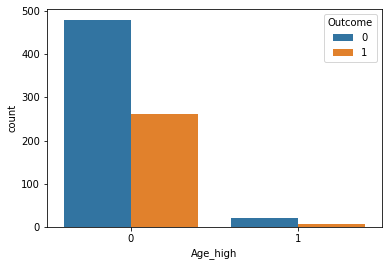

In [84]:
sns.countplot(data=df, x="Age_high", hue='Outcome') # high는 모수가 적다.

## 결측치 다루기
- 학습 목표
    - 결측치를 평균으로 일괄 채우는 방법을 알아봅니다.
    
- 핵심 키워드
    - isnull().sum()

In [113]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Pregnancies_high            0
Age_low                     0
Age_middle                  0
Age_high                    0
dtype: int64

In [180]:
df['Insulin_nan'] = df['Insulin'].replace(0, np.nan)
df[['Insulin', 'Insulin_nan']].head()

,Insulin,Insulin_nan
0,0,NaN
1,0,NaN
2,0,NaN
3,94,94.0
4,168,168.0


In [181]:
df['Insulin_nan'].isnull().sum()

374

In [182]:
# 결측치 비율

df['Insulin_nan'].isnull().mean() # 결측치 비율이 48%

0.4869791666666667

In [183]:
df.groupby(['Outcome'])['Insulin', 'Insulin_nan'].agg(['mean','median'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Insulin        Insulin_nan       
               mean median        mean median
Outcome                                      
0         68.792000     39  130.287879  102.5
1        100.335821      0  206.846154  169.5

In [184]:
# 결측치 채우기
# 당뇨병 발생했고(Outcome==1) 인슐린이 결측치인 값을 평균값인 206 으로 채워넣기
# 당뇨병 발생안했고(Outcome==0) 인슐린이 결측치인 값을 평균값인 130 으로 채워넣기
df.loc[(df['Outcome'] == 0) & (df['Insulin_nan'].isnull()), 'Insulin_nan'] = 102.5
df.loc[(df['Outcome'] == 1) & (df['Insulin_nan'].isnull()), 'Insulin_nan'] = 169.5
df[['Outcome', 'Insulin', 'Insulin_nan']].head()

,Outcome,Insulin,Insulin_nan
0,1,0,169.5
1,0,0,102.5
2,1,0,169.5
3,0,94,94.0
4,1,168,168.0


## 수치형 변수를 정규분포 형태로 만들기
- 학습목표
    - log변환을 하여 전처리하는 방법을 이해합니다.
    
- 핵심 키워드
    - 왜도
    - 첨도
    - 로그 변환

### 왜도, 첨도
- 치우쳐져 있는 값을 전처리 해줄 수 있음

<AxesSubplot:xlabel='Insulin', ylabel='Density'>

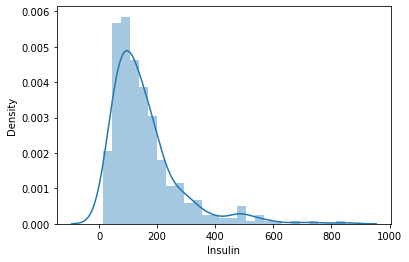

In [211]:
sns.distplot(df.loc[df['Insulin'] > 0, 'Insulin'])

<AxesSubplot:xlabel='Insulin', ylabel='Density'>

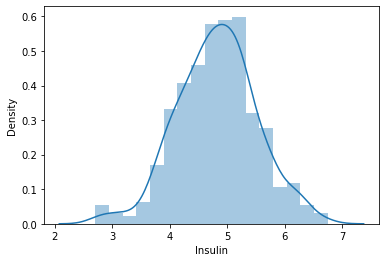

In [213]:
# 왼쪽으로 치우쳐져 있는값을 log를 씌워서 가운데쪽으로 만들어줬음.
# 머신러닝,딥러닝의 모델을 학습시킬때 정규분포화 된 데이터가 학습률이 더 좋다.

sns.distplot(np.log(df.loc[df['Insulin'] > 0, 'Insulin'] + 1))

<AxesSubplot:xlabel='Insulin_nan', ylabel='Density'>

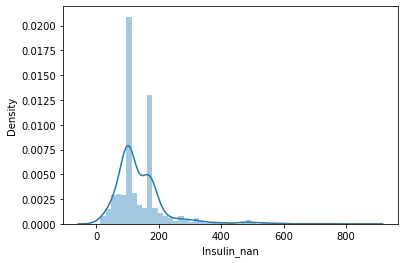

In [214]:
sns.distplot(df['Insulin_nan'])

<AxesSubplot:xlabel='Insulin_log', ylabel='Density'>

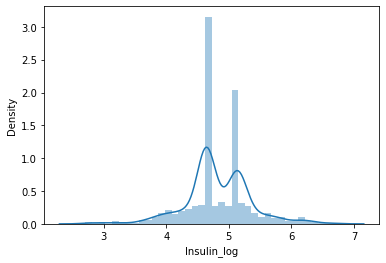

In [217]:
df['Insulin_log'] = np.log(df['Insulin_nan'] + 1) # 마이너스 무한대로 수렴하는것을 방지하기 위해 1 을 더해준다.
sns.distplot(df['Insulin_log'])

## 상관 분석을 통해 파생변수 만들기
- 학습목표
    - 상관계수를 이용해 파생변수를 만들 수 있습니다.
    
- 핵심 키워드
    - crosstab()
    - lmplot()

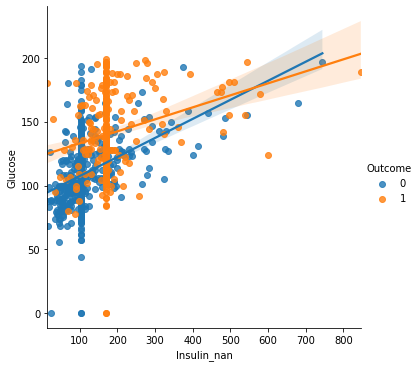

In [240]:
sns.lmplot(data=df, x='Insulin_nan', y='Glucose', hue='Outcome')

In [241]:
df['Glucose'] < 100

0      False
1       True
2      False
3       True
4      False
       ...  
763    False
764    False
765    False
766    False
767     True
Name: Glucose, Length: 768, dtype: bool

## 4. 학습, 예측 데이터셋 나누기

In [218]:
# 8:2 의 비율로 구하기 위해 전체 데이터의 행에서 80% 위치에 해당되는 값을 구해서 split_count 라는 변수에 담습니다.
split_count = int(df.shape[0] * 0.8)
split_count

614

In [219]:
# train, test로 슬라이싱을 통해 데이터를 나눕니다.
train = df[:split_count].copy()
train.shape

(614, 15)

In [220]:
# 20% 는 Test 데이터로 만듭니다.
test = df[split_count:].copy()
test.shape

(154, 15)

## 5. 학습, 예측에 사용할 컬럼

In [221]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
feature_names = train.columns.tolist()
feature_names.remove('Pregnancies')
feature_names.remove('Outcome')
feature_names.remove('Age_low')
feature_names.remove('Age_middle')
feature_names.remove('Age_high')
feature_names.remove('Insulin')
feature_names.remove('Insulin_nan')

feature_names

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Pregnancies_high',
 'Insulin_log']

## 6. 정답값이자 예측해야 될 값

In [222]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.
label_name = 'Outcome'
label_name

'Outcome'

## 7. 학습, 예측 데이터셋 만들기

In [223]:
# 학습 세트 만들기 예) 시험의 기출문제
X_train = train[feature_names]
print(X_train.shape)
X_train.head(3)

(614, 8)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_log
0,148,72,35,33.6,0.627,50,False,5.138735
1,85,66,29,26.6,0.351,31,False,4.639572
2,183,64,0,23.3,0.672,32,True,5.138735


In [224]:
# 정답 값을 만들어 줍니다. 예) 기출문제의 정답
y_train = train[label_name]
print(y_train.shape)
y_train.head(3)

(614,)


0    1
1    0
2    1
Name: Outcome, dtype: int64

In [225]:
# 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제
X_test = test[feature_names]
print(X_test.shape)
X_test.head(3)

(154, 8)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_log
614,138,74,26,36.1,0.557,50,True,4.976734
615,106,72,0,25.8,0.207,27,False,4.639572
616,117,96,0,28.7,0.157,30,False,4.639572


In [226]:
# 예측의 정답값 예) 실전 시험 문제의 정답
y_test = test[label_name]
print(y_test.shape)
y_test.head(3)

(154,)


614    1
615    0
616    0
Name: Outcome, dtype: int64

## 8. 머신러닝 알고리즘 가져오기
- 의사결정나무로 학습과 예측하기

- 핵심 키워드
    - DecisionTreeClassifier
    - fit, predict

In [227]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model

DecisionTreeClassifier()

## 9. 학습(훈련)
- 시험을 볼 때 기출문제(X_train)와 정답(y_train)을 보고 공부하는 과정과 유사합니다.

In [228]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

## 10. 예측
- 실전 시험문제(X_test)라고 보면 됩니다. 우리가 정답을 직접 예측합니다.

In [229]:
y_predict = model.predict(X_test)
y_predict[:5]

array([1, 0, 0, 0, 1])

## 11. 트리 알고리즘 분석하기
- 의사결정나무를 시각화 합니다.

- 학습목표
    - 모델을 시각화하여 분석하고, feature 중에서 모델에 영향을 미친 정도를 확인할 수 있습니다.
    - 정확도를 계산하는 방법을 이해합니다.

- 핵심 키워드
    - plot_tree
    - feature_importances
    - accuracy_score

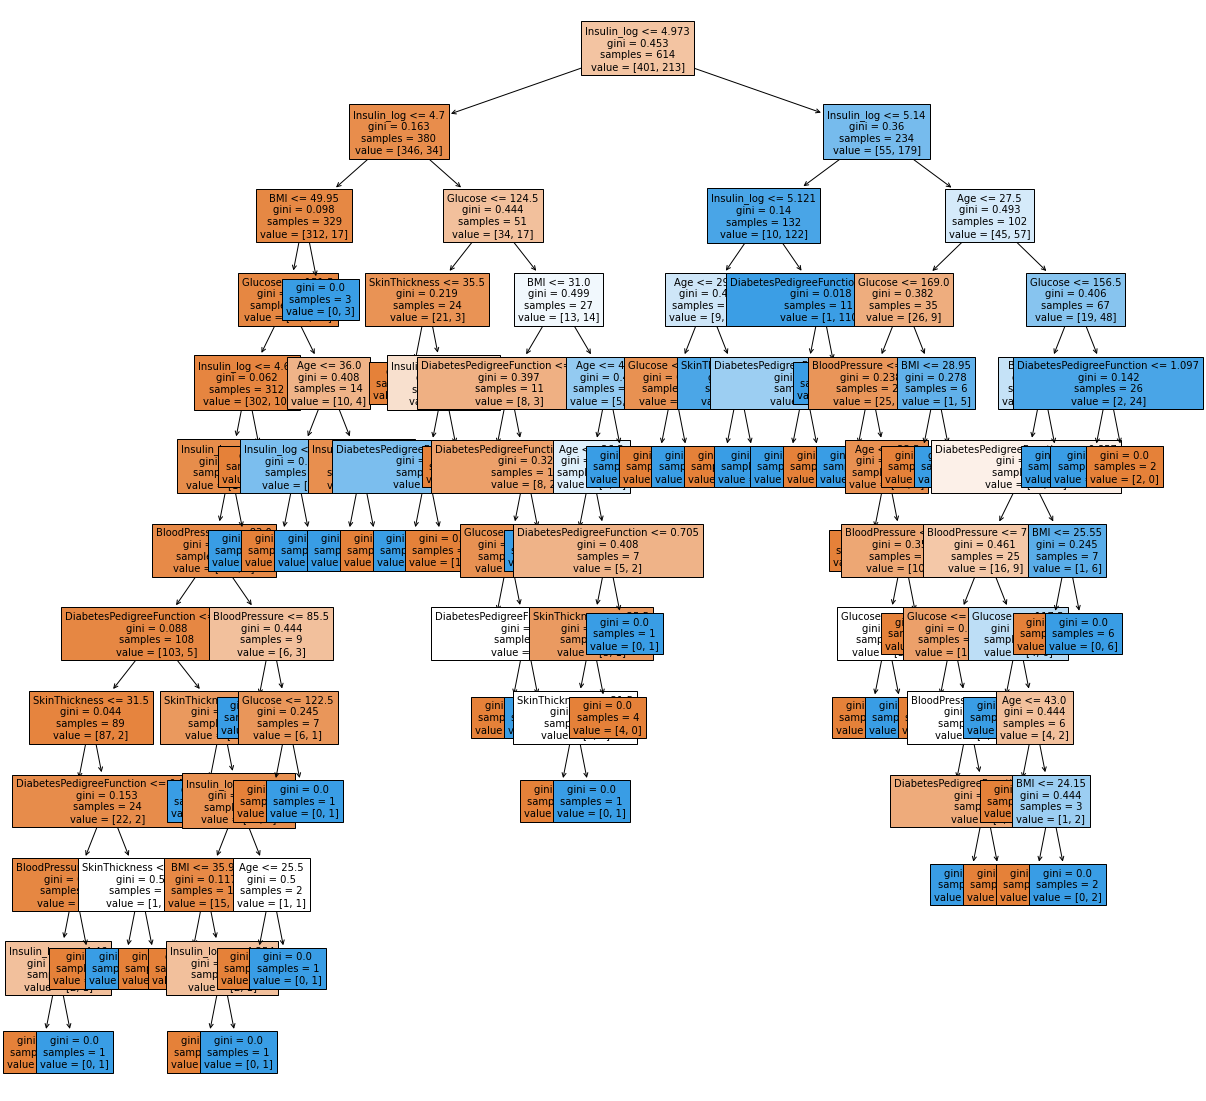

In [230]:
from sklearn.tree import plot_tree

plt.figure(figsize = (20, 20))
tree = plot_tree(
    model,
    feature_names = feature_names,
    filled = True,
    fontsize = 10
)

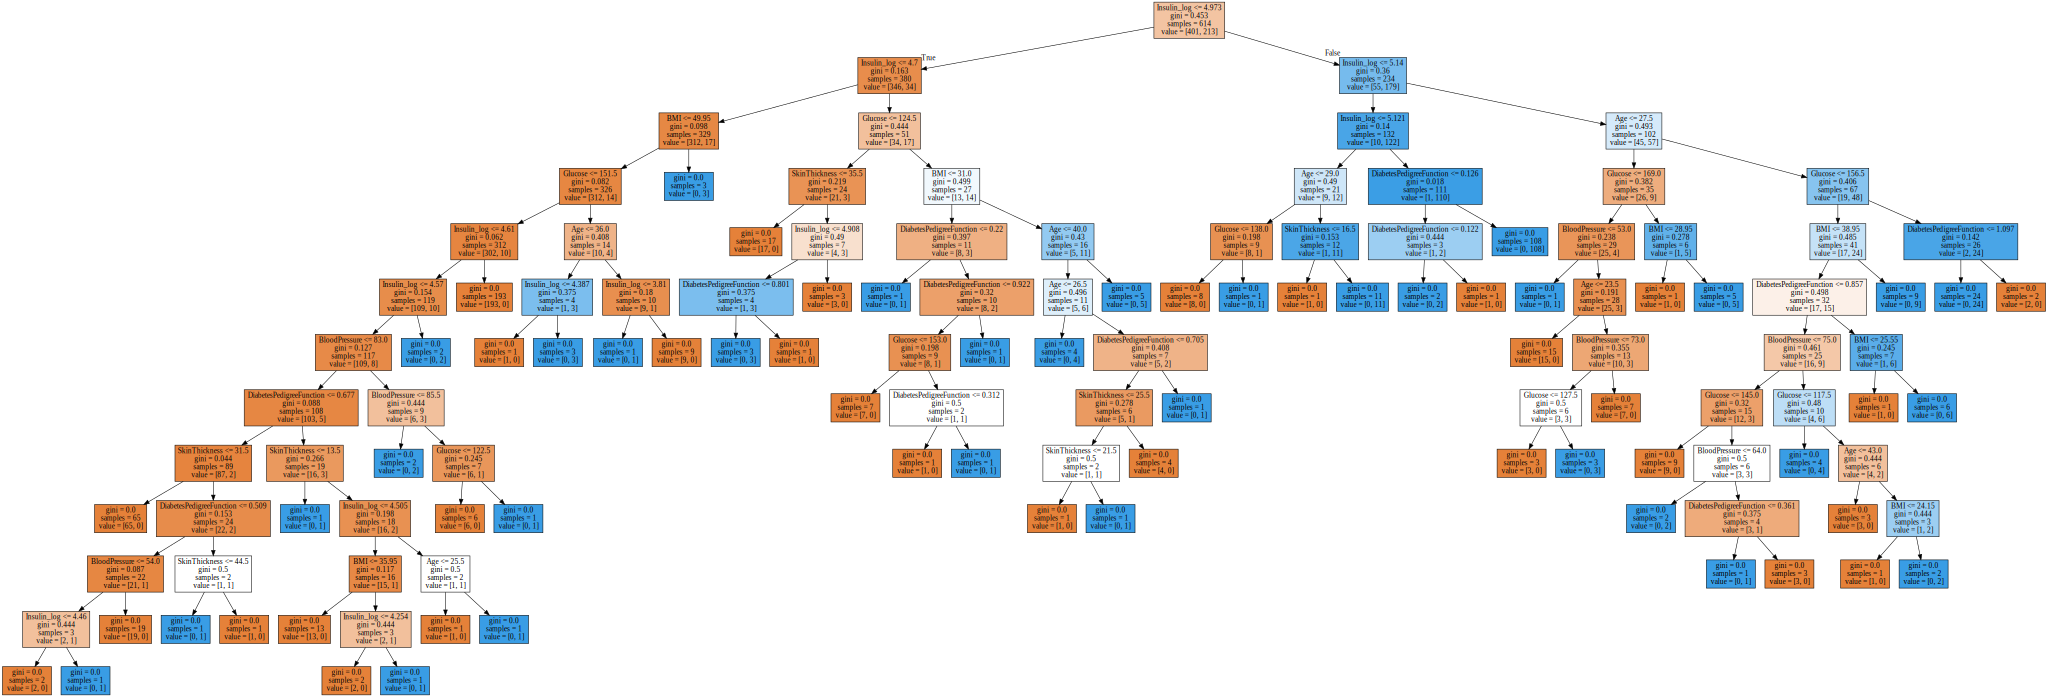

In [231]:
# graphviz 를 통해 시각화를 합니다.
# graphviz 는 별도의 설치가 필요합니다.
# graphviz 와 파이썬에서 graphviz 를 사용할 수 있게 해주는 도구 2가지를 설치해 주셔야 합니다.
import graphviz
from sklearn.tree import export_graphviz

dot_tree = export_graphviz(
    model,
    feature_names = feature_names,
    filled = True
)

graphviz.Source(dot_tree)

In [232]:
# 피처의 중요도를 추출하기
model.feature_importances_

array([0.09093577, 0.03883718, 0.02897707, 0.06077729, 0.06284889,
       0.09302282, 0.        , 0.62460097])

<AxesSubplot:>

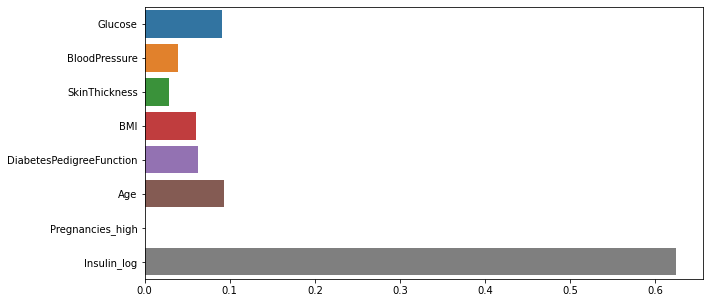

In [233]:
# 피처의 중요도 시각화 하기
plt.figure(figsize = (10, 5))
sns.barplot(
    y = feature_names,
    x = model.feature_importances_,
)

## 12. 정확도(Accuracy) 측정하기

In [235]:
# 실제값 - 예측값을 빼주면 같은 값은 0 으로 나오게 됩니다.
# 여기서 절대값을 씌운 값이 1인 값이 다르게 예측한 값이 됩니다.
# diff_count = abs(y_test - y_predict).sum() / len(y_test) # 26.6% 잘못 예측했다.

# 인슐린 0 이었던 결측치들 평균값으로 대체 해줬더니 정확도가 올라갔다. ( 43개 오답이었는데 27개로 줄어듬 )
# 인슐린 0 이었던 결측치들 중앙값으로 대체 해줬더니 정확도가 올라갔다. ( 27개 오답이었는데 19개로 줄어듬 )
# 인슐린 값이 편차가 커서 log처리를 하면 좀 더 좋은성능을 내기도한다. ( 정규분포랑 가까워지기 때문에 ) - 전처리방법중 하나

diff_count = abs(y_test - y_predict).sum()
diff_count

17

In [236]:
# 예측의 정학도를 구합니다. 100점 만점 중에 몇 점을 맞았는지 구한다고 보면 됩니다.
(len(y_test) - diff_count) / len(y_test) * 100

88.96103896103897

In [237]:
# 위에서 처럼 직접 구할 수도 있지만 미리 구현된 알고리즘을 가져와 사용합니다.
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_predict) * 100

88.96103896103897

In [238]:
# model 의 score 로 점수를 계산합니다.
model.score(X_test, y_test) * 100

88.96103896103897